Iteration: 100 Loss: 0.0070416
Iteration: 100 PSNR: 11.83
Iteration: 200 Loss: 0.0039291
Iteration: 200 PSNR: 12.39
Iteration: 300 Loss: 0.0026909
Iteration: 300 PSNR: 12.59
Iteration: 400 Loss: 0.0020051
Iteration: 400 PSNR: 12.65
Iteration: 500 Loss: 0.0015544
Iteration: 500 PSNR: 12.68


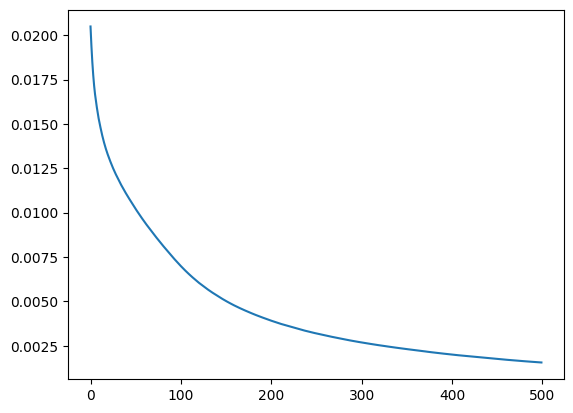

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import imageio
from skimage.metrics import peak_signal_noise_ratio as psnr

# DIP model
class HourglassNetwork(nn.Module):
    def __init__(self):
        super(HourglassNetwork, self).__init__()

        self.leaky_relu = nn.LeakyReLU()

        self.d_conv_1 = nn.Conv2d(2, 8, 5, stride=2, padding=2)
        self.d_bn_1 = nn.BatchNorm2d(8)

        self.d_conv_2 = nn.Conv2d(8, 16, 5, stride=2, padding=2)
        self.d_bn_2 = nn.BatchNorm2d(16)

        self.d_conv_3 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.d_bn_3 = nn.BatchNorm2d(32)
        self.s_conv_3 = nn.Conv2d(32, 4, 5, stride=1, padding=2)

        self.d_conv_4 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.d_bn_4 = nn.BatchNorm2d(64)
        self.s_conv_4 = nn.Conv2d(64, 4, 5, stride=1, padding=2)

        self.d_conv_5 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.d_bn_5 = nn.BatchNorm2d(128)
        self.s_conv_5 = nn.Conv2d(128, 4, 5, stride=1, padding=2)

        self.d_conv_6 = nn.Conv2d(128, 256, 5, stride=2, padding=2)
        self.d_bn_6 = nn.BatchNorm2d(256)

        self.u_deconv_5 = nn.ConvTranspose2d(256, 124, 4, stride=2, padding=1)
        self.u_bn_5 = nn.BatchNorm2d(128)

        self.u_deconv_4 = nn.ConvTranspose2d(128, 60, 4, stride=2, padding=1)
        self.u_bn_4 = nn.BatchNorm2d(64)

        self.u_deconv_3 = nn.ConvTranspose2d(64, 28, 4, stride=2, padding=1)
        self.u_bn_3 = nn.BatchNorm2d(32)

        self.u_deconv_2 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.u_bn_2 = nn.BatchNorm2d(16)

        self.u_deconv_1 = nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1)
        self.u_bn_1 = nn.BatchNorm2d(8)

        self.out_deconv = nn.ConvTranspose2d(8, 3, 4, stride=2, padding=1)
        self.out_bn = nn.BatchNorm2d(3)

    def forward(self, noise):
        down_1 = self.d_conv_1(noise)
        down_1 = self.d_bn_1(down_1)
        down_1 = self.leaky_relu(down_1)

        down_2 = self.d_conv_2(down_1)
        down_2 = self.d_bn_2(down_2)
        down_2 = self.leaky_relu(down_2)

        down_3 = self.d_conv_3(down_2)
        down_3 = self.d_bn_3(down_3)
        down_3 = self.leaky_relu(down_3)
        skip_3 = self.s_conv_3(down_3)

        down_4 = self.d_conv_4(down_3)
        down_4 = self.d_bn_4(down_4)
        down_4 = self.leaky_relu(down_4)
        skip_4 = self.s_conv_4(down_4)

        down_5 = self.d_conv_5(down_4)
        down_5 = self.d_bn_5(down_5)
        down_5 = self.leaky_relu(down_5)
        skip_5 = self.s_conv_5(down_5)

        down_6 = self.d_conv_6(down_5)
        down_6 = self.d_bn_6(down_6)
        down_6 = self.leaky_relu(down_6)

        up_5 = self.u_deconv_5(down_6)
        up_5 = torch.cat([up_5, skip_5], 1)
        up_5 = self.u_bn_5(up_5)
        up_5 = self.leaky_relu(up_5)

        up_4 = self.u_deconv_4(up_5)
        up_4 = torch.cat([up_4, skip_4], 1)
        up_4 = self.u_bn_4(up_4)
        up_4 = self.leaky_relu(up_4)

        up_3 = self.u_deconv_3(up_4)
        up_3 = torch.cat([up_3, skip_3], 1)
        up_3 = self.u_bn_3(up_3)
        up_3 = self.leaky_relu(up_3)

        up_2 = self.u_deconv_2(up_3)
        up_2 = self.u_bn_2(up_2)
        up_2 = self.leaky_relu(up_2)

        up_1 = self.u_deconv_1(up_2)
        up_1 = self.u_bn_1(up_1)
        up_1 = self.leaky_relu(up_1)

        out = self.out_deconv(up_1)
        out = self.out_bn(out)
        out = nn.Sigmoid()(out)

        return out

#Apply a random mask to the input image
def apply_mask(img, probability=0.5):
    assert 0 < probability < 1, 'Probability value should be between 0 and 1'
    mask = torch.rand(128, 128)
    img[:, :, mask < probability] = 0
    mask = mask > probability
    mask = mask.repeat(1, 3, 1, 1)
    return img, mask

learning_rate = 1e-4
device = 'cuda'

model = HourglassNetwork().to(device)

# from torchsummary import summary
# print(summary(model, input_size = (1, 2, 512, 512)))

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training parameters
num_iterations = 500
output_images = []
loss_values = []
to_tensor = tv.transforms.ToTensor()

# Generate Gaussian noise input
noise = torch.randn((1, 2, 128, 128)).to(device)

# Load and preprocess the image
image = Image.open('scenery.jpg').resize((128, 128))
image_tensor = to_tensor(image).unsqueeze(0)
masked_image, mask = apply_mask(image_tensor, 0.8)
mask = mask.to(device)
masked_image = masked_image.to(device)

# Training loop
for iteration in range(num_iterations):
    optimizer.zero_grad()
    output = model(noise)
    loss = loss_function(masked_image, output * mask)
    loss_values.append(loss.item())
    loss.backward()
    optimizer.step()

    if (iteration + 1) % 25 == 0 or iteration == 0:
        with torch.no_grad():
            inpainted_output = masked_image + output * ~mask
            inpainted_output = inpainted_output[0].cpu().detach().permute(1, 2, 0) * 255
            inpainted_output = np.array(inpainted_output, dtype=np.uint8)
            output_images.append(inpainted_output)
    
    if (iteration + 1) % 100 == 0:
        print(f'Iteration: {iteration + 1} Loss: {loss_values[-1]:.07f}')

        psnr_value = psnr(inpainted_output, np.array(image))
        print(f'Iteration: {iteration + 1} PSNR: {psnr_value:.2f}')

# Save results
plt.imsave('final.jpg', inpainted_output)
plt.imsave('start.jpg', masked_image[0].cpu().detach().permute(1, 2, 0).numpy())
plt.plot(loss_values)
imageio.mimsave('progress.gif', output_images)


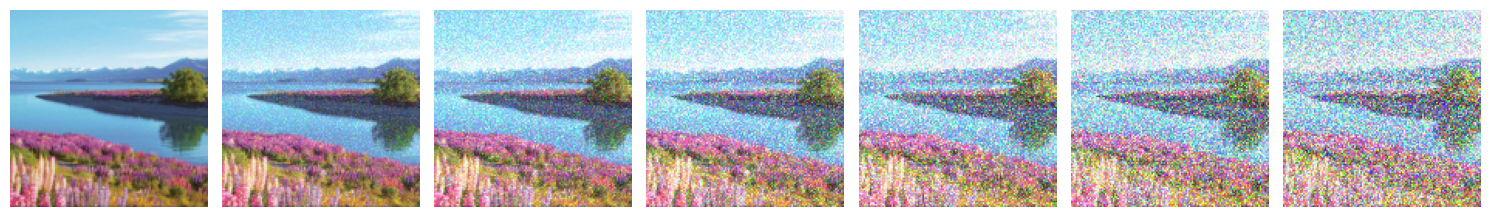

Epoch [0/30], Loss: 0.4936, PSNR: 4.8383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

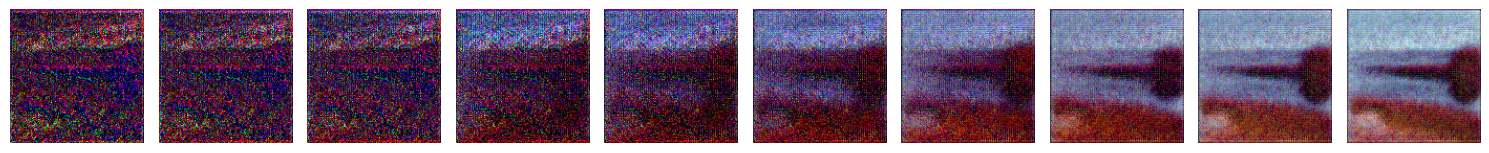

Epoch [10/30], Loss: 0.0861, PSNR: 15.2263


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

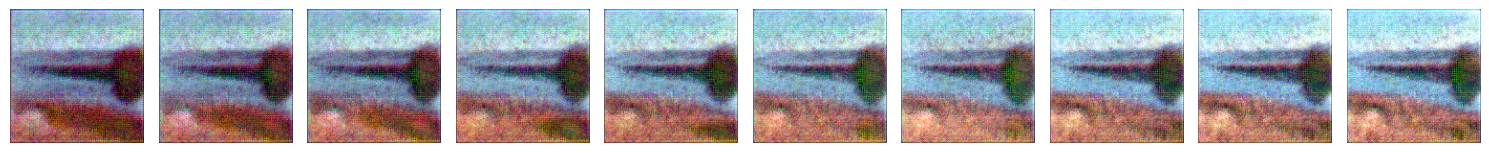

Epoch [20/30], Loss: 0.0264, PSNR: 18.0026


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

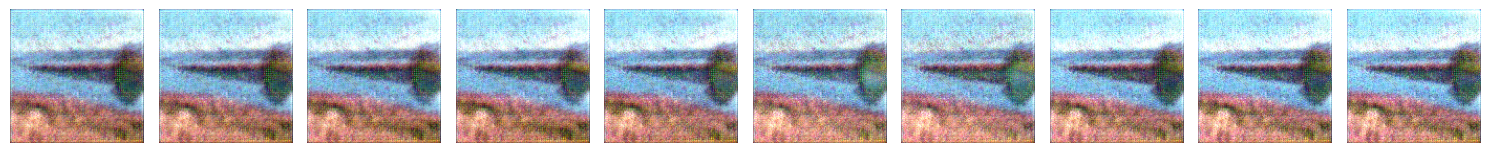

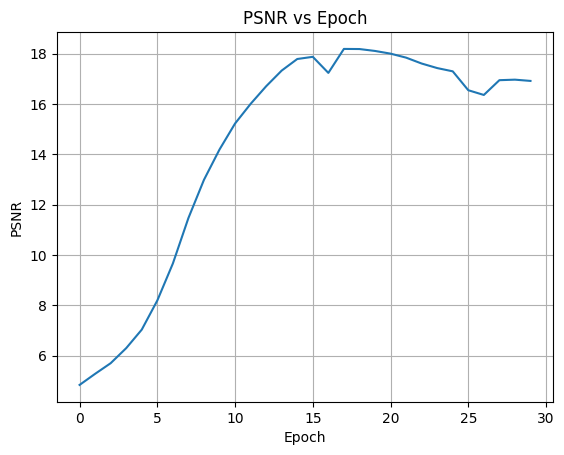

PSNR: 16.92


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

# DDPM model
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Unet, self).__init__()

        self.encoder1 = DoubleConv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, output_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)
        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)
        bottleneck = self.bottleneck(pool4)
        up4 = self.upconv4(bottleneck)
        merge4 = torch.cat([up4, enc4], dim=1)
        dec4 = self.decoder4(merge4)
        up3 = self.upconv3(dec4)
        merge3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.decoder3(merge3)
        up2 = self.upconv2(dec3)
        merge2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.decoder2(merge2)
        up1 = self.upconv1(dec2)
        merge1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.decoder1(merge1)
        final_output = self.final_conv(dec1)
        return final_output

# Add noise according to the given formula
def add_noise(x0, alpha_t):
    noise = abs(torch.normal(0, 0.6, x0.shape)).to("cuda")
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return noisy_image, noise

# Generate a dataset with increasing noise
def generate_noisy_dataset(image, num_steps):
    dataset = []
    betas = np.linspace(0.0001, 0.02, num_steps)
    alphas = np.cumprod(1 - betas)
    show_images = []

    for t in range(num_steps):
        alpha_t = torch.tensor(alphas[t], dtype=torch.float32).to(image.device)
        noisy_image, noise = add_noise(image, alpha_t)

        if t % 10 == 0 or t == num_steps - 1:
            show_images.append(torch.clip(noisy_image, 0, 1).squeeze().cpu().permute(1, 2, 0).numpy())

        # if t == num_steps - 1:
        #     plt.imsave("noisy_scenery.png", torch.clip(noisy_image, 0, 1).squeeze().cpu().permute(1, 2, 0).numpy())

        dataset.append((noisy_image, noise, alpha_t))

    if show_images:
        num_images = len(show_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i in range(num_images):
            axes[i].imshow(show_images[i])
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    return dataset

# Load and preprocess the image
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

image_path = 'scenery.jpg'
original_image = Image.open(image_path).convert('RGB')
original_image = transform(original_image).unsqueeze(0).to("cuda")

image_path = 'final.jpg'
noisy_scenery = Image.open(image_path).convert('RGB')
noisy_scenery = transform(noisy_scenery).unsqueeze(0).to("cuda")

# Hyperparameters
num_steps = 60
num_epochs = 30
learning_rate = 1e-5

dataset = generate_noisy_dataset(original_image, num_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(3, 3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnr_values = []

denoised_images = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for t in reversed(range(1, num_steps)):
        noisy_image, noise, alpha_t = dataset[t]
        noisy_image, noise = noisy_image.to(device), noise.to(device)

        optimizer.zero_grad()
        outputs = model(noise)
        loss = criterion(outputs, noisy_image)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Store denoised image and compute PSNR
    with torch.no_grad():
        # denoised_image = noisy_scenery
        # for t in reversed(range(1, num_steps)):
        #     denoised_image = model(denoised_image)

        denoised_image = model(noisy_scenery)

        denoised_image = denoised_image.squeeze().cpu().permute(1, 2, 0).numpy()
        ground_truth_image = original_image.squeeze().cpu().permute(1, 2, 0).numpy()
        epoch_psnr = psnr(ground_truth_image, denoised_image)
        psnr_values.append(epoch_psnr)

        denoised_images.append(denoised_image)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss/num_steps:.4f}, PSNR: {epoch_psnr:.4f}')

    if epoch % 10 == 9:
        num_images = len(denoised_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i in range(num_images):
            axes[i].imshow(denoised_images[i])
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig("epoch " + str(epoch - 9) + ".png")
        plt.show()

        denoised_images = []

# Plot PSNR vs Epochs
plt.plot(range(num_epochs), psnr_values)
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR vs Epoch')
plt.grid(True)
plt.show()

# Evaluate PSNR
ground_truth_image = original_image.squeeze().cpu().permute(1, 2, 0).numpy()
psnr_value = psnr(ground_truth_image, denoised_image)
print(f'PSNR: {psnr_value:.2f}')


DDPM Only


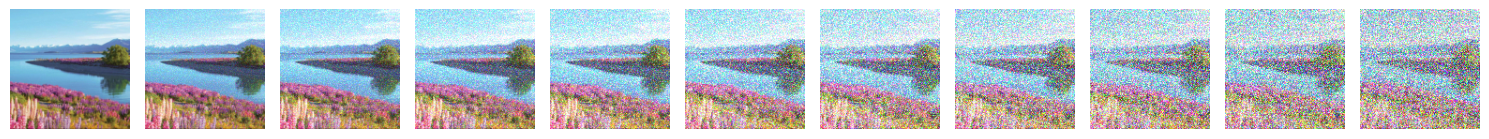

Epoch [0/30], Loss: 0.6394, PSNR: 3.6427


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

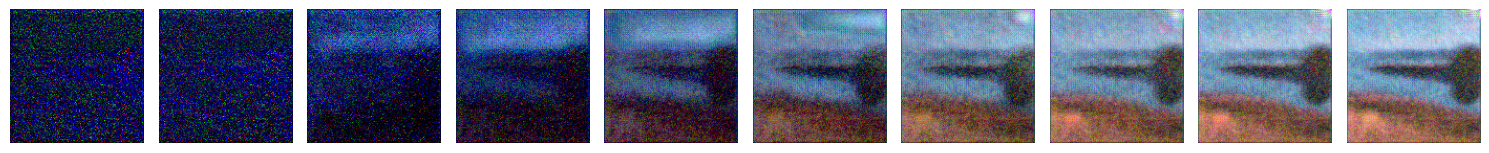

Epoch [10/30], Loss: 0.0587, PSNR: 17.8844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

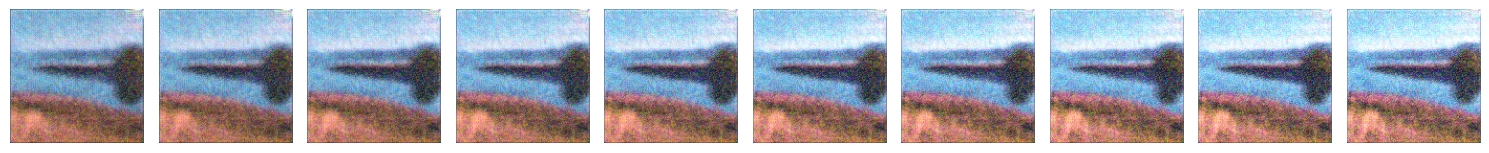

Epoch [20/30], Loss: 0.0237, PSNR: 17.1386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

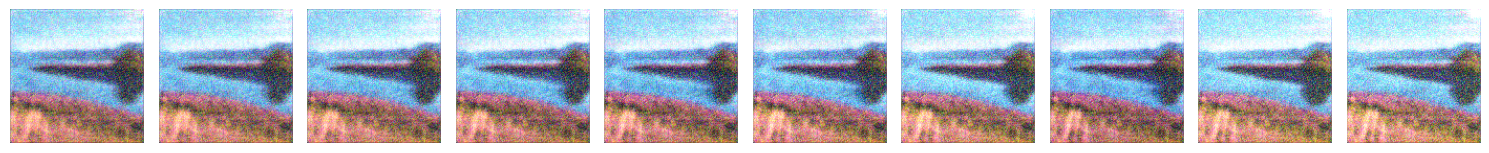

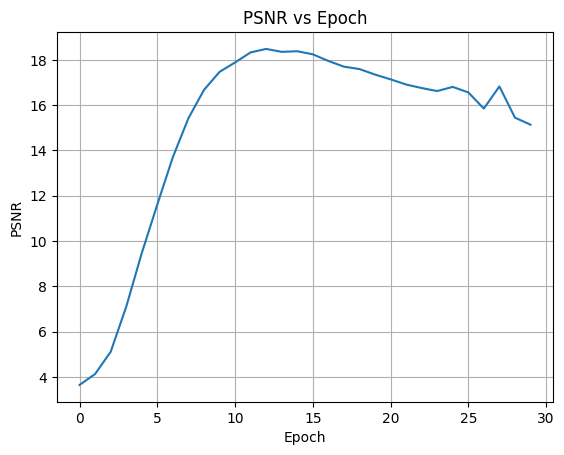

PSNR: 15.14


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

# DDPM model
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Unet, self).__init__()

        self.encoder1 = DoubleConv(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        self.final_conv = nn.Conv2d(64, output_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)
        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)
        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)
        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)
        bottleneck = self.bottleneck(pool4)
        up4 = self.upconv4(bottleneck)
        merge4 = torch.cat([up4, enc4], dim=1)
        dec4 = self.decoder4(merge4)
        up3 = self.upconv3(dec4)
        merge3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.decoder3(merge3)
        up2 = self.upconv2(dec3)
        merge2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.decoder2(merge2)
        up1 = self.upconv1(dec2)
        merge1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.decoder1(merge1)
        final_output = self.final_conv(dec1)
        return final_output

# Add noise
def add_noise(x0, alpha_t):
    noise = abs(torch.normal(0, 0.6, x0.shape)).to("cuda")
    noisy_image = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
    return noisy_image, noise

# Generate a dataset with increasing noise
def generate_noisy_dataset(image, num_steps):
    dataset = []
    betas = np.linspace(0.0001, 0.02, num_steps)
    alphas = np.cumprod(1 - betas)
    show_images = []

    for t in range(num_steps):
        alpha_t = torch.tensor(alphas[t], dtype=torch.float32).to(image.device)
        noisy_image, noise = add_noise(image, alpha_t)

        if t % 10 == 0 or t == num_steps - 1:
            show_images.append(torch.clip(noisy_image, 0, 1).squeeze().cpu().permute(1, 2, 0).numpy())

        if t == num_steps - 1:
            plt.imsave("noisy_scenery.png", torch.clip(noisy_image, 0, 1).squeeze().cpu().permute(1, 2, 0).numpy())

        dataset.append((noisy_image, noise, alpha_t))

    if show_images:
        num_images = len(show_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i in range(num_images):
            axes[i].imshow(show_images[i])
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    return dataset

# Load and preprocess the image
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

image_path = 'scenery.jpg'
image = Image.open(image_path).convert('RGB')
image = transform(image).unsqueeze(0).to("cuda")

# Hyperparameters
num_steps = 100
num_epochs = 30
learning_rate = 1e-5

dataset = generate_noisy_dataset(image, num_steps)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(3, 3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

psnr_values = []

denoised_images = []

image_path = 'noisy_scenery.png'
noisy_scenery = Image.open(image_path).convert('RGB')
noisy_scenery = transform(noisy_scenery).unsqueeze(0).to("cuda")

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for t in reversed(range(1, num_steps)):
        noisy_image, noise, alpha_t = dataset[t]
        noisy_image, noise = noisy_image.to(device), noise.to(device)

        optimizer.zero_grad()
        outputs = model(noise)
        loss = criterion(outputs, noisy_image)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Store denoised image and compute PSNR
    with torch.no_grad():
        # denoised_image = noisy_scenery
        # for t in reversed(range(1, num_steps)):
        #     denoised_image = model(denoised_image)

        denoised_image = model(noisy_scenery)

        denoised_image = denoised_image.squeeze().cpu().permute(1, 2, 0).numpy()
        ground_truth_image = image.squeeze().cpu().permute(1, 2, 0).numpy()
        epoch_psnr = psnr(ground_truth_image, denoised_image)
        psnr_values.append(epoch_psnr)

        denoised_images.append(denoised_image)

    # Print epoch loss
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss/num_steps:.4f}, PSNR: {epoch_psnr:.4f}')

    if epoch % 10 == 9:
        num_images = len(denoised_images)
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

        for i in range(num_images):
            axes[i].imshow(denoised_images[i])
            axes[i].axis('off')

        plt.tight_layout()
        plt.savefig("epoch " + str(epoch - 9) + ".png")
        plt.show()

        denoised_images = []

# Plot PSNR vs Epochs
plt.plot(range(num_epochs), psnr_values)
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR vs Epoch')
plt.grid(True)
plt.show()

# Evaluate PSNR
ground_truth_image = original_image.squeeze().cpu().permute(1, 2, 0).numpy()
psnr_value = psnr(ground_truth_image, denoised_image)
print(f'PSNR: {psnr_value:.2f}')